In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#GlobalFinMonthly
url="https://raw.githubusercontent.com/amoreira2/Lectures/main/assets/data/GlobalFinMonthly.csv"
Data = pd.read_csv(url,na_values=-99)
Data['Date']=pd.to_datetime(Data['Date'])
Data=Data.set_index(['Date'])
Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })
Re=(Data.drop('RF',axis=1)).subtract(Data['RF'],axis='index')

# What is a trading strategy?

* A trading strategy is a procedure that maps any information known up to time t, into a set of trading instructions for time  $T>t$.

   - This means, that formally the mean-variance analysis we did so far was not evaluated as a trading strategy since we used data of the whole sample to estimate the weights of our strategy and evalauted the strategy

* The weights of a trading strategy must either:
   * Add up to 1. So it describes what you do with your entire capital.
   * Or add up to 0. So the strategy is self-financing. For example, borrow 1 dollar at the risk-free rate and buy 1 dollar worth of the market portfolio
   * Every time you trade on the excess returns, you can think of the weights "adding up to zero"

* It is very important that the trading strategy only uses information that is known at the time of the trade, otherwise it is not a valid trading strategy-- you obviously cannot trade on info that you don't know

* It is very important that you are clear about where the dollars that you invest come from, so that the weights can add up to 1 (if you have some capital) or zero (if the strategy is self-financed and demand zero capital).

  * In practice all strategies demand capital as no bank allow us to borrow without putting some capital in, but these self financed strategies are quite convenient to work with as they are all in the "Excess Return Space" since they have zero cost. 
  
  * we will discuss how shorting requires capital in detail 

**Examples**

* Example of a VALID trading strategy: Every monday buy stocks that had positive news coverage during the weekend and sell stocks that had negative news coverage.
  * This is valid because you are trading after the information is known.

* Example of INVALID trading strategy: On Friday buy all the stocks that will have positive news coverage during the weekend, and sell all the stocks that will have negative coverage during the weekend.

   * This is Invalid because you are trading before the information is known.
   
* This might sound ridicoulous. Obviously you can not trade on the information that is not known at the time of the trade!

* But note that we will be "simulating" the trading process using HISTORICAL data, so we can easily get confused and use "future" information in the strategy construction process.

   - In fact that was exactly what we did in our mean-variance analysis!



**Types of trading strategies**

- Strategic allocation: How you allocate across broad asset classes: Cash, Equities (US, Developed Markets, Emerging Markets), Government bonds (US, ...), Corporate bonds(US, ...), Commodities, Private equity, real assets (land,...)
    -  The strategy takes positions on broader asset classes. For example pension funds tend to follow a 70-30 split between equity and bonds
    -  An example is of this is the mean-variance anaylsis we did last few chapters.
    -  We will revisit this here but now making the analysis more tight
    -  Another example is RISK-PARITY which we will discuss later

- Timing: Easier to think in terms of one risky asset and cash. The strategy basically goes in and out of an asset according to some model that forecasts time-variaiton either in returns of the risky asset realitve to cash or in it's riskness
    - You obvioulsy can time multiple things at the same time, but it is useful separation to help understand what the strategy is doing
    
- Cross-sectional (within asset class): This is about how you invest within an asset class. The "defaul" option is to do a market-cap weighted portfolio which we will discuss below. The cross-sectional strategies use some information to deviate from the market portfolio in the asset class
    - The are cross-sectional strategies everywhere: equities, gov bonds, corp bonds, futures, equity indexes, currencies, commodities, options, crypto currrencies
    - All these asset classes have lots of data and are naturally a good place to do quantitative investing
    - For this class we focus on equities


**Quantitative trading strategies**

* In this class we will focus on quantitative trading strategies. 

* Stragies that get some hard data about one or multiple assets and transform this data "mechanically"  into  portfolio weights

* So given data $X_{t}$, a quatitative trading strategy is a function that maps data into weights $W_{t+1}=f(X_t)$


**Our First Quantitative Strategy**

Our MV optimization was quantitative but it would be only a valid strategy if we used future data to evaluate it.
 
So one option would be to wait for new data to evaluate. 
 
Here what we will do is to do the mean-variance analysis assuming I am an investor that is doing this in real time, so I will say the investor will start in 1973, 10 years after the beggining of the sample and simply use the past data to estimate the means and covariances, compute the weights and invest on the assets according to this strategy for the next month.
 
I will do that for the entire sample.
 
This will be valid because at not moment I will use information that an investor would not have had available in real time. 

___
*An aside*

It is also valid in another conceputal sense: Markowitz dissertation was published in 1954, so in 73 we would know how to use these techiniques. This sounds strange, but this type of validity is important for example when we evalaute trading strategies associated with published papers. When we look back in the sample before the paper existed in some way we are endowing the information that he didn't have even if he might have the informaation that he needs to construc the trading signals
____

We will construct a portolio that in tagency in the estimating sample and in the estimation sample has a volatility of 15%.

We will start by using jsut the first 10 years and evalauting on the rest of the sample as a warm up


In [9]:
Re.std()*12**0.5


MKTUS      0.152891
BondUS     0.121331
EM         0.206581
MKTxUS     0.161802
BondxUS    0.069854
dtype: float64

Warm up

In [12]:

Results=pd.DataFrame([],index=[])

Endofsample=1973
sigmaD=0.15/(12**0.5)
#Estiamte moments up to 1973
ERe=Re[:str(Endofsample)].mean()
CovRe=Re[:str(Endofsample)].cov()
# construct weights and normalize them so the have desired volatility
W=np.linalg.inv(CovRe) @ ERe* (sigmaD/(ERe @ np.linalg.inv(CovRe) @ ERe)**0.5)

Results.at['avgreturn','estimationsample']=W @ ERe*12
Results.at['volatility','estimationsample']=(W @ CovRe @ W*12)**0.5
Results.at['shaperatio','estimationsample']=Results.at['avgreturn','estimationsample']/Results.at['volatility','estimationsample']
ERetest=Re[str(Endofsample+1):].mean()
CovRetest=Re[str(Endofsample+1):].cov()
Results.at['avgreturn','testsample']=W @ ERetest*12
Results.at['volatility','testsample']=(W @ CovRetest @ W*12)**0.5
Results.at['shaperatio','testsample']=Results.at['avgreturn','testsample']/Results.at['volatility','testsample']
Results

,estimationsample,testsample
avgreturn,0.102715,-0.014757
volatility,0.150000,0.284975
shaperatio,0.684767,-0.051783


- Look how bad this is
- The average excess return ends up negative!
- The volatility ends up as much twice as large
- If you look at the diagonal you see that the test sample was substantially more volatile

In [11]:
W

array([ 0.48594363, -0.56158479,  0.69192728,  0.06004647, -2.618298  ])

In [13]:
CovRe

,MKTUS,BondUS,EM,MKTxUS,BondxUS
MKTUS,0.001460,0.000232,0.000160,0.000508,0.000101
BondUS,0.000232,0.000683,-0.000219,-0.000025,0.000015
EM,0.000160,-0.000219,0.002450,0.000567,0.000107
MKTxUS,0.000508,-0.000025,0.000567,0.001025,0.000143
BondxUS,0.000101,0.000015,0.000107,0.000143,0.000081


In [15]:
CovRetest

,MKTUS,BondUS,EM,MKTxUS,BondxUS
MKTUS,0.002072,0.000076,0.001581,0.001454,0.000207
BondUS,0.000076,0.001360,-0.000200,-0.000013,0.000323
EM,0.001581,-0.000200,0.003842,0.001940,0.000285
MKTxUS,0.001454,-0.000013,0.001940,0.002476,0.000491
BondxUS,0.000207,0.000323,0.000285,0.000491,0.000487


In lots of ways this being too tought on the investor. He/She had to stick with the same weights as even as new data rolled in.

So now we will do somethign a bit more sophisitcated and re-estimate our weights every month starting in 1973

The investor will have the entrie data up to that year to construct it's weights

In [24]:
Re.loc[Re.index[119]]

MKTUS      0.006200
BondUS     0.022583
EM         0.062621
MKTxUS     0.029464
BondxUS   -0.000907
Name: 1972-12-31 00:00:00, dtype: float64

In [99]:
InSampleResults=pd.DataFrame([],index=[])
Strategy=pd.DataFrame([],index=[])
sigmaD=0.15/(12**0.5)
# I will start buildign portfolios in the end of 1972 so my first return will be january 1973 
# and will use data up do december 1972
for date in Re['1973-1':].index:
    # I am using DateOffset function to tell python to stop on month before 
    # so the estiamtion sample will be all months up to one month before the return that I 
    #I will be trading
    # this guarantees the strategy is VALID with respect to information
    ERe=Re[:date- pd.DateOffset(months=1)].mean()
    CovRe=Re[:date- pd.DateOffset(months=1)].cov()
# construct weights and normalize them so the have desired volatility
    W=np.linalg.inv(CovRe) @ ERe* (sigmaD/(ERe @ np.linalg.inv(CovRe) @ ERe)**0.5)

    InSampleResults.at[date,'avgreturn']=W @ ERe*12
    InSampleResults.at[date,'volatility']=(W @ CovRe @ W*12)**0.5
    InSampleResults.at[date,'sharperatio']=W @ ERe*12/(W @ CovRe @ W*12)**0.5
    Strategy.at[date,'Returns']=W @ Re.loc[date]


Text(0.5, 1.0, 'Sharpe Ratio')

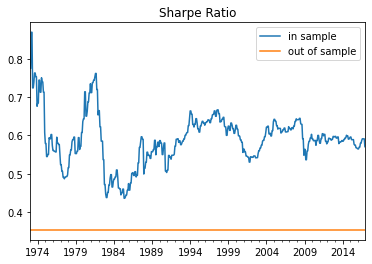

In [83]:
ax=plt.Figure()
InSampleResults.sharperatio.plot()
# Iam using this as trick to plot an horizontal line. So I am getting the dataframing with all the dates and simply subsituting the value of Sharpe ratio below
OutofSample=InSampleResults.sharperatio.copy()
OutofSample[:]=(Strategy.Returns.mean()*12)/(Strategy.Returns.std()*12**0.5)
OutofSample.plot()
plt.legend(['in sample','out of sample'])
plt.title('Sharpe Ratio')


It is interesting also to look at the average reutrns and volatility in a rolling basis

Text(0.5, 1.0, 'Volatility')

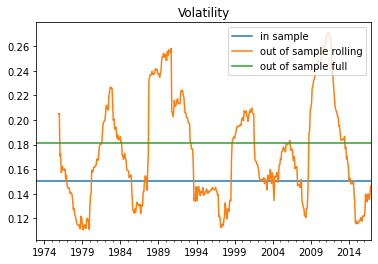

In [81]:
ax=plt.Figure()
axis=InSampleResults.volatility.plot()
OutofSample=(Strategy.Returns.rolling(window=36).std()*12**0.5)
OutofSample.plot()
OutofSample[:]=(Strategy.Returns.std()*12**0.5)
OutofSample.plot()
plt.legend(['in sample','out of sample rolling','out of sample full'])
plt.title('Volatility')

Text(0.5, 1.0, 'Average Return')

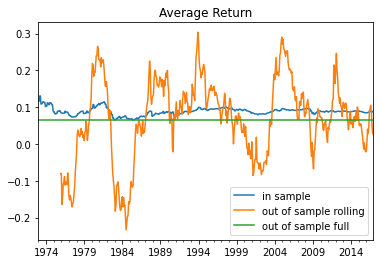

In [82]:
ax=plt.Figure()
axis=InSampleResults.avgreturn.plot()
OutofSample=(Strategy.Returns.rolling(window=36).mean()*12)
OutofSample.plot()
OutofSample[:]=(Strategy.Returns.mean()*12)
OutofSample.plot()
plt.legend(['in sample','out of sample rolling','out of sample full'])
plt.title('Average Return')

**Practical approaches to deal with Estimation Uncertainty in the Mean-Variance framework**

In econometrics there is a whole field dedicated towards finding features of the data that are "robust". Features that don't vary too much from sample to sample.

As you can see this can be super useful here. 

This techniques get complicated very quickly with Bayesian methods, Shrinkage methods, and so on. Well beyond the scope of this class.

The industry however uses two approaches that attempt to get at that by de-emphasizing information about the pieces of the data that we are most uncertain about.

Two approaches are particularly popular


  * Minimum-variance investing
  
  * Risk parity
  


**Minimum-variance investing**


* Mean-variance investing under the assumption that all assets have same expected returns, but uses covariance matrix to minimize risk

 * The idea is that expected returns signals are pure noise so we might as well assume there are no signals and all expected returns are the same
  
 * For example this is behind Minimum volatility investing for example, [https://investor.vanguard.com/mutual-funds/profile/VMVFX]
  
* Assumes all assets have the same expected return

$$Min~ W'Var(R)W~ subject~ to~ \mathbf{1}'W=1$$

$$W_{minvariance}\propto Var(R)^{-1}\mathbf{1}$$

Imposing the constraint: 
$$W_{minvariance}=\frac{Var(R)^{-1}\mathbf{1}}{\mathbf{1}^TVar(R)^{-1}\mathbf{1}}$$

* I use this technique in "hedging-risk factors", a recent academic paper, to construct portfolios with Sharpe-ratios of 0.8 at the yearly horizon, which is very large

> Why this might make sense?

So you see here that the problem is really identical to the mean-variance problem. We simply substituted the vector or Expected returns by a vector of ones.

The end result is that now the solution is the portfolio that minimizes variance while being fully invested as the constraint $\mathbf{1}'W=1$ means $\sum_i^I w_i*1=1$



In [98]:
InSampleResults=pd.DataFrame([],index=[])
Strategy=pd.DataFrame([],index=[])
sigmaD=0.15/(12**0.5)
Emv=np.ones(Re.shape[1])
for date in Re['1973-1':].index:
    ERe=Re[:date- pd.DateOffset(months=1)].mean()
    CovRe=Re[:date- pd.DateOffset(months=1)].cov()
     # the only difference is that now I use the vector ones instead of 
        #sample means for expected returns
    W=np.linalg.inv(CovRe) @ Emv * (sigmaD/(Emv @ np.linalg.inv(CovRe) @ Emv)**0.5)

    InSampleResults.at[date,'avgreturn']=W @ ERe*12
    InSampleResults.at[date,'volatility']=(W @ CovRe @ W*12)**0.5
    InSampleResults.at[date,'sharperatio']=W @ ERe*12/(W @ CovRe @ W*12)**0.5
    Strategy.at[date,'Returns']=W @ Re.loc[date]


Text(0.5, 1.0, 'Sharpe Ratio')

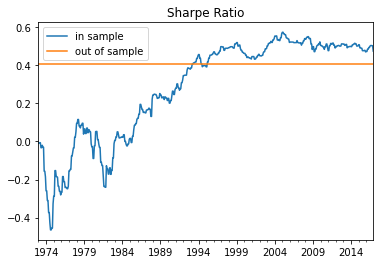

In [86]:
ax=plt.Figure()
InSampleResults.sharperatio.plot()
# Iam using this as trick to plot an horizontal line. So I am getting the dataframing with all the dates and simply subsituting the value of Sharpe ratio below
OutofSample=InSampleResults.sharperatio.copy()
OutofSample[:]=(Strategy.Returns.mean()*12)/(Strategy.Returns.std()*12**0.5)
OutofSample.plot()
plt.legend(['in sample','out of sample'])
plt.title('Sharpe Ratio')


**Risk- Parity**


* Risk-parity investing: Mean-variance investing under the assumption that all expected returns are equal, and the correlations across all assets are zero. 
  * Sometimes the assumption is that all Sharpe Ratios are equal 
  * This is the strategy behind the biggest hedge funds on the planet [https://www.bridgewater.com/resources/our-thoughts-about-risk-parity-and-all-weather.pdf]
  

* It assumes that the non-diagonal terms in the covariance matrix are all zero.

$$Var_{RP}(R)=diag(Var(R))=\left[\begin{array}{ccc}\sigma_1^2 & 0 & 0\\0 & \sigma_2^2 &0 \\0 & 0& \sigma^2_3\end{array}\right]$$

* we then have 

$$Min~ W'Var_{RP}(R)W ~ subject~ to~ \mathbf{1}'W=1$$

* it follows

$$W_{RP}\propto Var_{RP}(R)^{-1}\mathbf{1}=\left[\begin{array}{c}\frac{1}{\sigma_1^2}\\\frac{1}{\sigma_2^2}\\\frac{1}{\sigma_3^2}\end{array}\right]$$



* another implementation is one where the Sharpe Ratio is the same across assets, so the Expected return scales with volatility.

$$E_{RP}(R)=\left[\begin{array}{ccc}\sigma_1\\\sigma_2\\\sigma_3\end{array}\right]\times SR$$


$$W_{RP}=Var_{RP}(R)^{-1}E_{RP}[R]=\left[\begin{array}{ccc}\sigma_1^2 & 0 & 0\\0 & \sigma_2^2 &0 \\0 & 0& \sigma^2_3\end{array}\right]^{-1}\left[\begin{array}{ccc}\sigma_1\\\sigma_2\\\sigma_3\end{array}\right]\times SR=SR\left[\begin{array}{c}\frac{1}{\sigma_1}\\\frac{1}{\sigma_2}\\\frac{1}{\sigma_3}\end{array}\right]$$


$$W_{RP}\propto \left[\begin{array}{c}\frac{1}{\sigma_1}\\\frac{1}{\sigma_2}\\\frac{1}{\sigma_3}\end{array}\right]$$

In the first approach you invest inversely proportional to variance

In the second approach you invest inversely proportional to volatility

The important point is that estimate even less moments than the minimum-variance approach. Now it assumes all correlations are zero

> Why this might make sense?

> Why does the assumption of ZERO correlation a conservative ASSUMPTION?


Below we will implement the second approach.

The key trick that we will use is the `np.diag()` function to extract the diagonal of the covariance matrix when applied to a matrix and to build a matrix only with the diagonal terms when applied to a vector

In [92]:
1/np.diag(Re.cov())

array([ 513.35357526,  815.14734135,  281.19004241,  458.3662201 ,
       2459.19902061])

In [90]:
np.diag(np.diag(Re.cov()))

array([[0.00194798, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00122677, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00355631, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00218166, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00040664]])

In [97]:
InSampleResults=pd.DataFrame([],index=[])
Strategy=pd.DataFrame([],index=[])
sigmaD=0.15/(12**0.5)

Ones=np.ones(Re.shape[1])

for date in Re['1973-1':].index:
    ERe=Re[:date- pd.DateOffset(months=1)].mean()
    CovRe=Re[:date- pd.DateOffset(months=1)].cov()
    
    # this below is the key difference where I coistruct the covriance 
    # and the expected returns under the risk parity assumption to construc the weights 
    CovRP=np.diag(np.diag(Re[:date- pd.DateOffset(months=1)].cov()))
    ERP=np.diag(Re[:date- pd.DateOffset(months=1)].cov())**0.5

    W=np.linalg.inv(CovRP) @ ERP * (sigmaD/(ERP @ np.linalg.inv(CovRP) @ ERP)**0.5)

    InSampleResults.at[date,'avgreturn']=W @ ERe*12
    InSampleResults.at[date,'volatility']=(W @ CovRe @ W*12)**0.5
    InSampleResults.at[date,'sharperatio']=W @ ERe*12/(W @ CovRe @ W*12)**0.5
    Strategy.at[date,'Returns']=W @ Re.loc[date]


Text(0.5, 1.0, 'Sharpe Ratio')

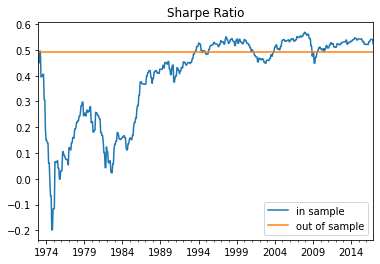

In [95]:
ax=plt.Figure()
InSampleResults.sharperatio.plot()
# Iam using this as trick to plot an horizontal line. So I am getting the dataframing with all the dates and simply subsituting the value of Sharpe ratio below
OutofSample=InSampleResults.sharperatio.copy()
OutofSample[:]=(Strategy.Returns.mean()*12)/(Strategy.Returns.std()*12**0.5)
OutofSample.plot()
plt.legend(['in sample','out of sample'])
plt.title('Sharpe Ratio')


**The Market-Cap Weighted strategy**

This is the foundational quantitative strategy. It used to be that people when started investing in the market would start by choosing a few stocks. It made sense. It was super costly to trade multiple stocks. You had to be crazy wealthy to have a fully diversified portfolio of stocks

So Vanguard comes along and start offering mutual funds that invest in all assets of a given asset class by simply by them in proportion to their market values.

So in this case $M_t=[m_t^{AAPL},m_t^{GOOG},m_t^{TSLA},..]$ has the market capitalization of all the assets in the universe. Where market capitalization is simply

$$m_t^{AAPL}=P^{AAPL}_t\times SharesOutstanding^{AAPL}$$

The strategy then set the weights simply to 

$$W_t=\frac{M_t}{\sum_i^Im^i_t}$$


So at end of month t you look at the market caps, construct the weights and buy the stocks accordingly earning $W_tR_{t+1}$ the end of the next month

This portfolio has lots of beautiful properties

1. In aggregate people will have to hold this portfolio, so the Capital Asset Pricing Model intuition tell us that this portfolio should be at the tangency frontier (in reality it is not--more on that coming-- but it should at least be much closer to it then a a portfolio made of a just a few stocks)


2. This portfolio is very easy to trade. First it does not require re-balancing as you weights naturally go up if the stock rallies and go down if the stock crashes
   - It only has to responds to share issuance and buybacks
   - and of course if a new firms comes in the asset space or if leaves
   
3. You can implement this approach to any subset of firms (for example SP500 or Russel2000) are market cap indexes that track a particular universe of stocks


Market caping is really the norm across the board. so that is the foundational trading strategy. Lots of what we do later will be about using signals to find subsets of stocks to group together and create market cap weighted portfolios of them

So I think a good start is to construct the market cap portfolio for the US equity market

**Download data from WRDS**

You will be required to put your name and password if you have it


In [28]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
###################
# Connect to WRDS. #
# You will be required to put your name and password if you have it
###################
conn=wrds.Connection() 

###################
# This below dowloads from the server the data that we want #
###################
crsp_m = conn.raw_sql("""
                      select a.permno, a.date, b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc,a.retx
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2005' and '12/31/2020'
                      and b.exchcd between 1 and 3
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 

# this saves it
#crsp_m.to_pickle('../../assets/data/crspm2005_2020.pkl')
# variables downloaded

# 1. Permno-- are unique indentifier to a security 
# (for exmaple a stock that has multiple types of stocks will have multiple permnos)

# 2. shrco is the type of share: common share, ADR, ETF, ....
# we will focus on common shares

# 3. exchcd is the code of the exchange where the stock was originally listed
# we will focus on stock listed in the 3 major stock exchanges ( basically the whole market)

# 4. ret,retx, shrout,  prc, are the stock return, the stock return excluding dividends, number of shares outstanding, and price

# 5. date is the trading date of the return



Enter your WRDS username [Alan.Moreira]: moreira5
Enter your password: ···········


WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


____
*If you don't want to deal with that you can simply get the data by running the code below*

In [42]:

crsp_m=pd.read_pickle('https://github.com/amoreira2/Lectures/blob/main/assets/data/crspm2005_2020.pkl?raw=true')

**Organizing the data**

The objective here is to have a data set with 

- Security identifier
- Date of the information
- Monthly return of the firm in that month
- Market capitalization of the firm in that month

**Note**

In this data set negative price mean that there was not trade in the last trading day of the month of the particular stock. So the value is the negative of the mid point in these date

price if no trade=$-\frac{Ask+Bid}{2}$

So we either drop those observations or simply take the absolute value, which is simply using the mid point to compute the market cap

Using Mid point is completely fine here. It would be more problematic if that was determining the prices that we trade.

In [30]:
# change variable format to int
crsp=crsp_m[['permno','date','ret','shrout','prc']].copy()
crsp[['permno']]=crsp[['permno']].astype(int)
# Line up date to be end of month
crsp['date']=crsp['date']+MonthEnd(0)
# add delisting return

# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.drop(['prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['date','permno','me'])
crsp

,permno,date,ret,me
41,10001,2005-01-31,-0.040580,1.717890e+04
75,10002,2005-01-31,-0.132466,2.352984e+05
287,10012,2005-01-31,-0.320388,1.661240e+04
491,10025,2005-01-31,0.277966,1.590375e+05
573,10026,2005-01-31,-0.015909,4.364695e+05
...,...,...,...,...
762874,93422,2020-12-31,0.484472,5.806171e+05
763257,93423,2020-12-31,0.109665,2.897716e+06
763342,93426,2020-12-31,0.076239,3.951370e+05
763505,93434,2020-12-31,0.122605,9.810226e+04


**Constructing returns of the market cap weighted portfolios**

The returns of the cap weighted 

$$R^{mkt}_{t+1}=\sum_i^I\frac{m^i_t}{\sum_i^Im^i_t}R^i_{t+1}$$

To implement this we need to first lag the market cap so our weights depend only on available data at the time of the trade.

To do that we will use the `.shift(d)` which "lags" the data by d periods.

I use brackets here because it simply shifts the rows. So you have to make sure that it is actually lagging by date. 

The way to do that is to  group by security and applying the shift within security.

>Why this is important?

Because the data set is stacked so when you shift the first month of security n, it will end up returning the last month of security n-1.

By grouping by we simply assign a missing value there since we don't have the data

In [32]:
crsp['me_l1']=crsp.groupby(['permno']).me.shift(1)

In [33]:
Rmkt=crsp.groupby(['date']).apply(lambda x:(x.ret*(x.me_l1/x.me_l1.sum())).sum())

So in the code above `(x.me/x.me.sum())` is the weights, which for each date will return a vector that adds up to one. and of course `x.ret` is the vector of returns

The code `(x.ret*(x.me/x.me.sum())` multiplies the return of each asset by the weight and then we sum if all up to get the reutrn of the portfolio

```(x.ret*(x.me/x.me.sum())).sum()```

The `groupby(['date'])` method groups the data by month so we obtain the return of the portfolio in that month



<AxesSubplot:xlabel='date'>

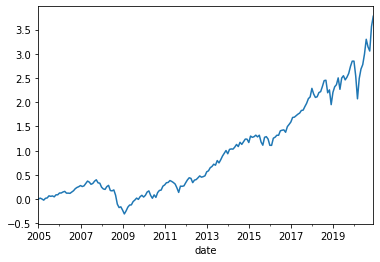

In [35]:
#Lets look at the cumulative returns
((Rmkt+1).cumprod()-1).plot()

<AxesSubplot:xlabel='date'>

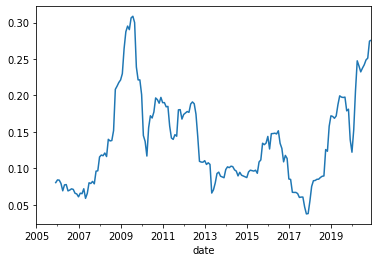

In [40]:
#Lets look at rolling volatility
(Rmkt.rolling(window=12).std()*12**0.5).plot()